# PCA visualization

Yao Fu. University of Edinburgh\
yao.fu@ed.ac.uk\
Mon Jun 21 2021

In [3]:
import torch 
import sklearn

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from pandas import DataFrame

from tqdm import tqdm 
from data_utils import News20Data
from transformers import BertModel, BertTokenizer

In [4]:
sns.set(rc={'figure.figsize':(8,8), 'figure.dpi': 200})
plt.rcParams["font.family"] = "DejaVu Sans"

In [5]:
dataset = News20Data(batch_size=20)

Processing dataset ...
Reading data ...
... 0 seconds
Tokenizing and sorting train data ...
... 111 seconds
Tokenizing and sorting dev data ...
... 37 seconds
Tokenizing and sorting test data ...
... 37 seconds


In [6]:
dev_loader = dataset.val_dataloader(shuffle=True)

In [7]:
bert = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
bert.to('cuda')

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [9]:
ckpt = torch.load('../models/bertnet_0.0.4.10.3/e9-model.pt')

In [10]:
ckpt['state_matrix'].size()

tensor([[-0.1243, -0.0418,  0.0489,  ...,  0.0069, -0.0661, -0.0424],
        [-0.1413, -0.0597,  0.0534,  ...,  0.0536, -0.0663, -0.0230],
        [-0.1063, -0.0363,  0.0363,  ...,  0.0070, -0.0721, -0.0442],
        ...,
        [-0.0858, -0.0052,  0.0568,  ...,  0.0177, -0.0474, -0.0010],
        [-0.1334,  0.1278,  0.1421,  ..., -0.1064, -0.1419, -0.0304],
        [ 0.0638, -0.0040, -0.0221,  ..., -0.0053, -0.0163,  0.0140]],
       device='cuda:0')

In [11]:
embeddings = []
tokens = []
# TODO: check the token length problem 
with torch.no_grad():
    for bi, batch in tqdm(enumerate(dev_loader)):
        if(bi == 500): break
        emb = bert(batch['input_ids'].to('cuda'), batch['attention_mask'].to('cuda'))[0]
        for bi in batch['input_ids']:
            t = tokenizer.convert_ids_to_tokens(bi)
            tokens.extend(t)
        embeddings.append(emb.view(-1, 768))

500it [00:14, 34.05it/s]


In [12]:
len(tokens)

416240

In [13]:
embeddings = torch.cat(embeddings, 0).view(-1, 768)

In [14]:
embeddings.size()

torch.Size([416240, 768])

In [15]:
pca = PCA(n_components=2)

In [16]:
pca.fit(embeddings.cpu())

PCA(n_components=2)

In [17]:
emb_transform = pca.transform(embeddings.cpu())

In [19]:
emb_transform.shape

(416240, 2)

In [18]:
state_transform = pca.transform(ckpt['state_matrix'].cpu())

In [20]:
state_transform.shape

(2000, 2)

In [21]:
emb_background = []
emb_bg_words = []


emb_dynamic_words = []
emb_dynamic = []

emb_static_words = []
emb_static = []

emb_cls = []
emb_sep = []
for w, e in zip(tokens, emb_transform):
    emb_bg_words.append(w)
    emb_background.append(e)

    if(w in ['man', 'woman']): 
        emb_static.append(e)
        emb_static_words.append(w)
    elif(w == '[CLS]'): 
        emb_cls.append(e)
    elif(w == '[SEP]'):
        emb_sep.append(e)
    elif(w in ['of', 'is']):
        emb_dynamic.append(e)
        emb_dynamic_words.append(w)
            
emb_background = np.array(emb_background)
emb_cls = np.array(emb_cls)
emb_sep = np.array(emb_sep)
emb_dynamic = np.array(emb_dynamic)
emb_static = np.array(emb_static)

In [22]:
# randomly sample state matrix
num_state = 200
# state_matrix = np.random.choice(emb_background.shape[0], num_state, replace=False)
state_matrix = state_transform

near_state_from = []
near_state_to = []
for i, si in enumerate(state_matrix):
    near_dist = 100000
    near_state = -1
    for j, sj in enumerate(state_matrix):
        if(i == j): continue
        dist = ((si - sj)**2).sum()
        if(dist < near_dist):
            near_dist = dist
            near_state = sj
    near_state_from.append(si)
    near_state_to.append(near_state)

# Plot All

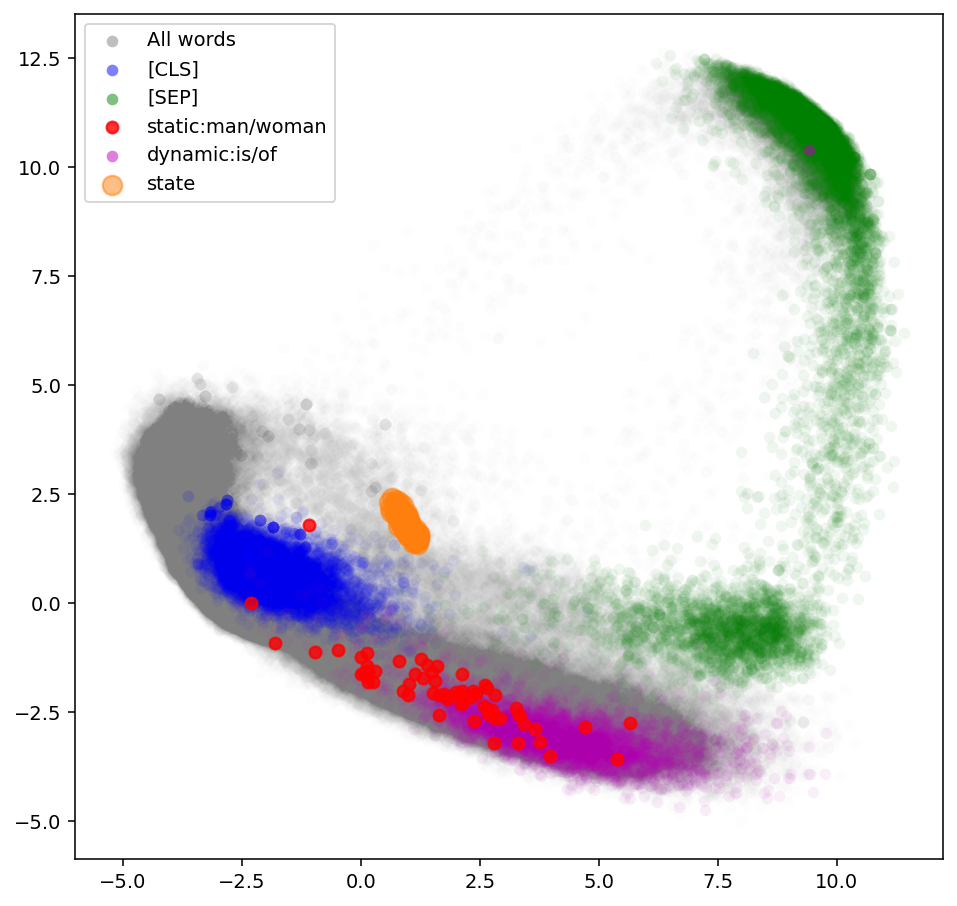

In [23]:
# emb = {'x': emb_vis[:, 0], 'y':emb_vis[:, 1], 
#        'token': tokens_, 'word_type': types, 'alpha': alpha
#       }
# emb = DataFrame(emb)

# colors = np.zeros((emb_vis.shape[0], 4))
# colors[:, 0] = 1.0
# colors[:, 3] = 0.1

# visualize all words as background
plt.scatter(x=emb_background[:, 0], y=emb_background[:, 1], color='0.5', alpha=0.01, linewidths=0)
fig_all = plt.scatter(x=emb_background[0, 0], y=emb_background[0, 1], color='0.5', alpha=0.5, linewidths=0)

# CLS 
plt.scatter(x=emb_cls[:, 0], y=emb_cls[:, 1], color='b', alpha=0.05, linewidths=0)
fig_cls = plt.scatter(x=emb_cls[0, 0], y=emb_cls[0, 1], color='b', alpha=0.5, linewidths=0)

# SEP
plt.scatter(x=emb_sep[:, 0], y=emb_sep[:, 1], color='g', alpha=0.05, linewidths=0)
fig_sep = plt.scatter(x=emb_sep[0, 0], y=emb_sep[0, 1], color='g', alpha=0.5, linewidths=0)

# is/ of
plt.scatter(x=emb_dynamic[:, 0], y=emb_dynamic[:, 1], color='m', alpha=0.05, linewidths=0)
fig_dynamic = plt.scatter(x=emb_sep[0, 0], y=emb_sep[0, 1], color='m', alpha=0.5, linewidths=0)

# man/ woman
fig_static = plt.scatter(x=emb_static[:, 0], y=emb_static[:, 1], color='r', linewidths=1.2, marker='o', alpha=0.8)

# state
fig_state = plt.scatter(x=state_matrix[:, 0], y=state_matrix[:, 1], color='tab:orange', s=100, linewidths=1.2, marker='o', alpha=0.5)

for si, sj in zip(near_state_from, near_state_to):
    plt.plot([si[0], sj[0]], [si[1], sj[1]], color='tab:orange', linestyle=':')

# TODO: latent states and their connectivity

# plt.xlim([-5, 10])
# plt.ylim([-5, 7.5])

plt.legend((
    fig_all, 
    fig_cls, 
    fig_sep, 
    fig_static, 
    fig_dynamic, 
    fig_state
    ), (
    'All words', 
    '[CLS]', 
    '[SEP]', 
    'static:man/woman', 
    'dynamic:is/of', 
    'state'
    ))
# visualize all 
# visualize 
# plt.scatter(x=emb.x, y=emb.y, color=colors)
# g0 = sns.scatterplot(x="x", y="y", hue="token", style='word_type', data=emb[emb.word_type == 'static'], alpha=1)
# g1 = sns.scatterplot(x="x", y="y", hue="token", style='word_type', data=emb[emb.word_type == 'dynamic'], alpha=0.1)
# plt.legend(handles=[g0, g1])

# States Only